In [27]:
import numpy as np
import rasterio
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score


In [4]:
# Load the predictor variables
with rasterio.open(r'data\aggregated_over_years_model_input\sm_max_pro.tif') as src:
    sm_max = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\sm_min_pro.tif') as src:
    sm_min = src.read(1)  # Read the first band

with rasterio.open(r'data\aggregated_over_years_model_input\sm_range_pro.tif') as src:
    sm_range = src.read(1)  # Read the first band

# Load the response variable
with rasterio.open(r'data\dead\deadwood.tif') as src:
    deadwood = src.read(1)  # Read the first band

In [59]:
# Flatten the arrays to 1D
sm_max_flat = sm_max.flatten()
sm_min_flat = sm_min.flatten()
sm_range_flat = sm_range.flatten()
deadwood_flat = deadwood.flatten()

# Stack predictor variables into a single array
X = np.column_stack((sm_max_flat, sm_min_flat, sm_range_flat))
y = deadwood_flat

# Remove rows with NAs and entries with -32768.0 in deadwood_flat
mask = ~np.isnan(X).any(axis=1) & ~np.isnan(y) & (y != -32768.0)
X_clean = X[mask]
y_clean = y[mask]

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=400)


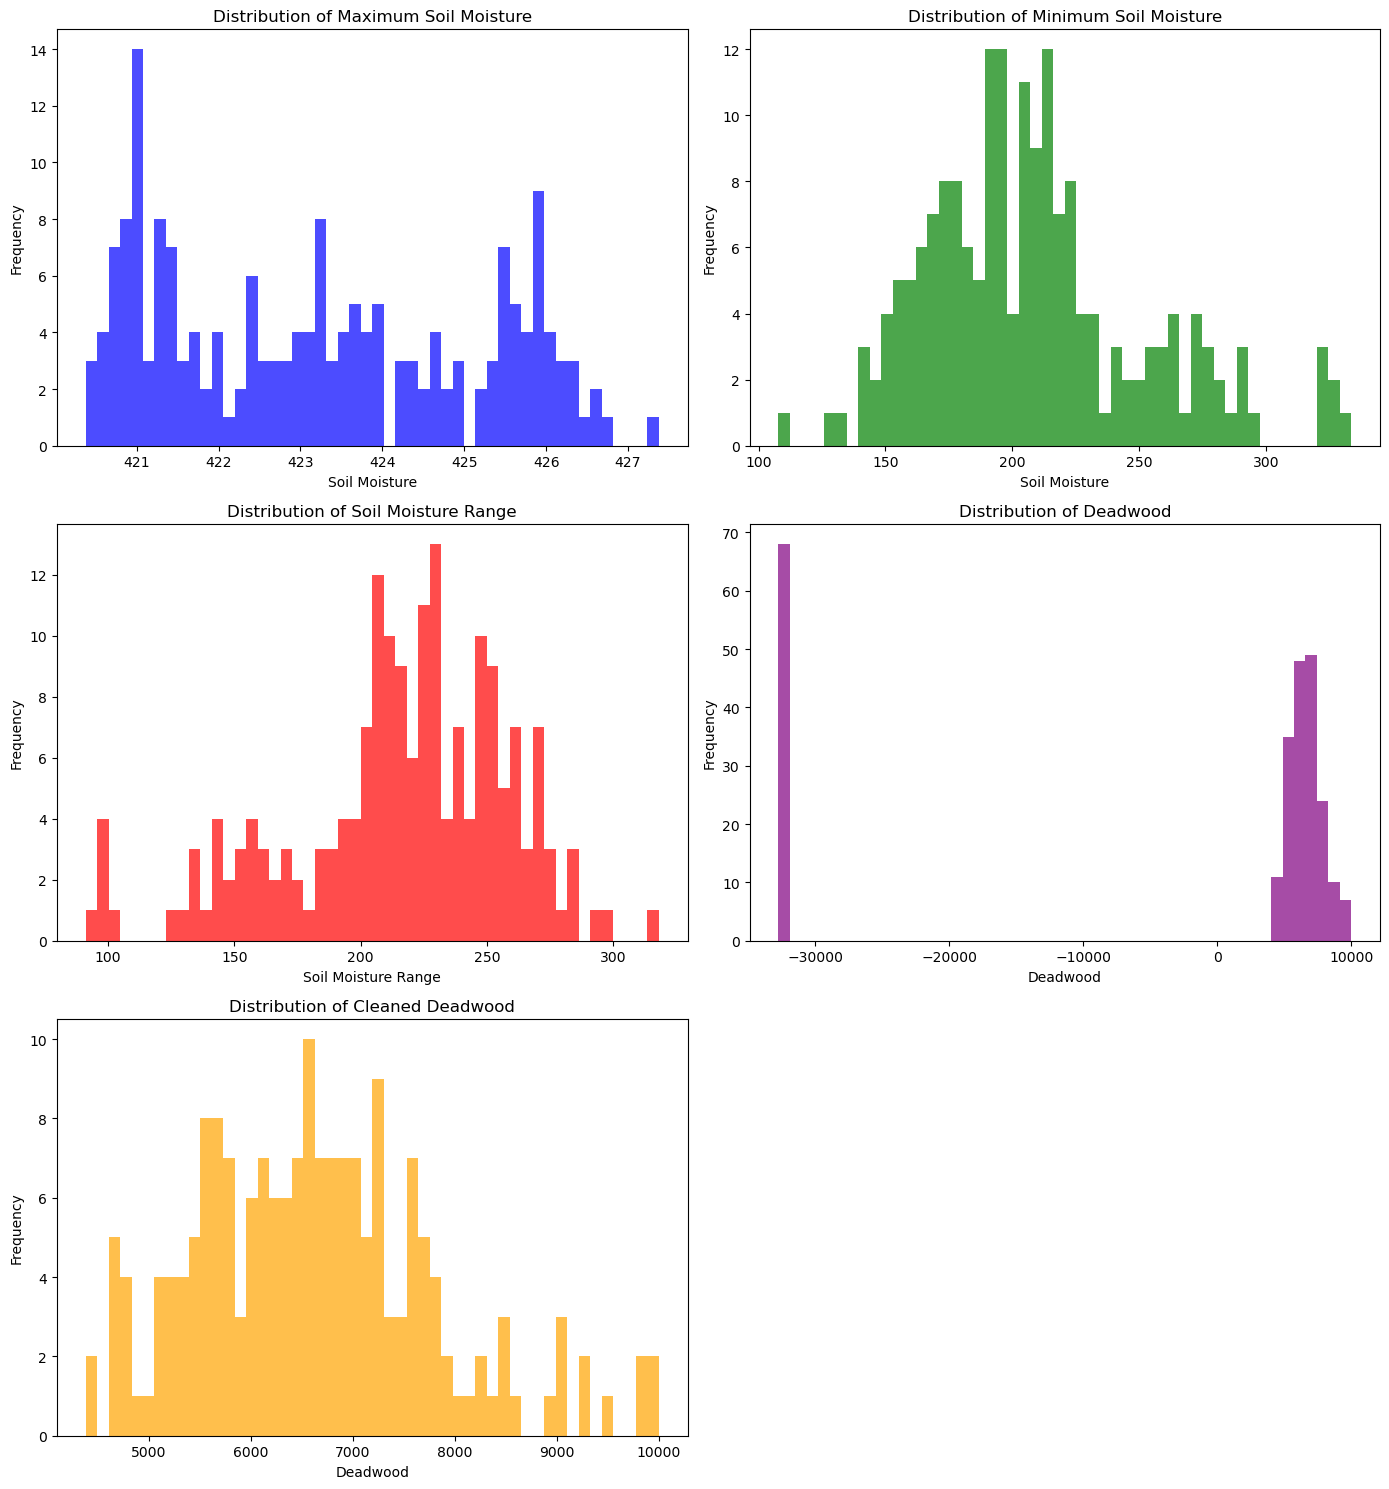

In [60]:
import matplotlib.pyplot as plt

# Setting up the figure and axes for the histograms
fig, axes = plt.subplots(3, 2, figsize=(14, 15))  # 3 rows, 2 columns, adjust size as necessary

# Histogram for Maximum Soil Moisture
axes[0, 0].hist(sm_max_flat, bins=50, color='blue', alpha=0.7)
axes[0, 0].set_title('Distribution of Maximum Soil Moisture')
axes[0, 0].set_xlabel('Soil Moisture')
axes[0, 0].set_ylabel('Frequency')

# Histogram for Minimum Soil Moisture
axes[0, 1].hist(sm_min_flat, bins=50, color='green', alpha=0.7)
axes[0, 1].set_title('Distribution of Minimum Soil Moisture')
axes[0, 1].set_xlabel('Soil Moisture')
axes[0, 1].set_ylabel('Frequency')

# Histogram for Soil Moisture Range
axes[1, 0].hist(sm_range_flat, bins=50, color='red', alpha=0.7)
axes[1, 0].set_title('Distribution of Soil Moisture Range')
axes[1, 0].set_xlabel('Soil Moisture Range')
axes[1, 0].set_ylabel('Frequency')

# Histogram for Deadwood
axes[1, 1].hist(deadwood_flat, bins=50, color='purple', alpha=0.7)
axes[1, 1].set_title('Distribution of Deadwood')
axes[1, 1].set_xlabel('Deadwood')
axes[1, 1].set_ylabel('Frequency')

# Histogram for Cleaned Deadwood (y_clean)
axes[2, 0].hist(y_clean, bins=50, color='orange', alpha=0.7)
axes[2, 0].set_title('Distribution of Cleaned Deadwood')
axes[2, 0].set_xlabel('Deadwood')
axes[2, 0].set_ylabel('Frequency')

# Leave the last subplot empty (or remove it if not needed)
axes[2, 1].axis('off')  # Turn off the 6th subplot if not used

# Improving layout to prevent overlap
plt.tight_layout()
plt.show()


In [56]:
deadwood_flat.min()

-32768.0

In [70]:
# Initialize the Random Forest regressor
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=1)

rf = RandomForestRegressor(n_estimators=1000, random_state=1, oob_score=True)

# Train the model
rf.fit(X_train, y_train)

print(rf.oob_score_)

# Check accuracy using R^2 score
accuracy = rf.score(X_test, y_test)
print(f"R^2 Score: {accuracy:.2f}")

print(f"Accuracy: {accuracy:.2f}")

0.38436568044445396
R^2 Score: 0.39
Accuracy: 0.39


## with CV

In [65]:
# Perform five-fold cross-validation

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_clean, y_clean, test_size=0.2, random_state=45)
cv_scores = cross_val_score(rf, X_clean, y_clean, cv=5, scoring='r2')

# Calculate the mean and standard deviation of the cross-validation scores
cv_mean = cv_scores.mean()
cv_std = cv_scores.std()

print(f"5-Fold CV R^2 Scores: {cv_scores}")
print(f"Mean CV R^2 Score: {cv_mean:.2f}")
print(f"Standard Deviation of CV R^2 Scores: {cv_std:.2f}")

5-Fold CV R^2 Scores: [-3.71243723e+00  2.94926166e-03 -9.26805474e-02 -8.99258710e-01
 -5.93245986e+00]
Mean CV R^2 Score: -2.13
Standard Deviation of CV R^2 Scores: 2.33
